In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pyro

/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [4]:
import muvi
import cellij
from cellij.core.synthetic import DataGenerator
from cellij.core._pyro_models import Generative, HorseshoeGenerative, LassoGenerative
from cellij.core._pyro_guides import Guide, HorseshoeGuide, LassoGuide
# from muvi import DataGenerator
from cellij.core.models import MOFA

In [5]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7fc723d48b50>


In [6]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

In [7]:
# random seed to use throughout the notebook
seed = 123

# basic parameters
n_samples = 200
n_features = [200, 300, 400, 500]
n_views = len(n_features)
likelihoods = ["Normal" for _ in range(n_views)]

# more specific parameters to the structure of the latent factors
n_fully_shared_factors = 20
n_partially_shared_factors = 0
n_private_factors = 0

# optional: number of covariates to generate
n_covariates = 0

In [8]:
dg = DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_fully_shared_factors,
    n_partially_shared_factors,
    n_private_factors,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# center data
dg.normalize(with_std=False)

2023-05-09 17:15:36,908 - cellij.core.synthetic - WARNING - Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

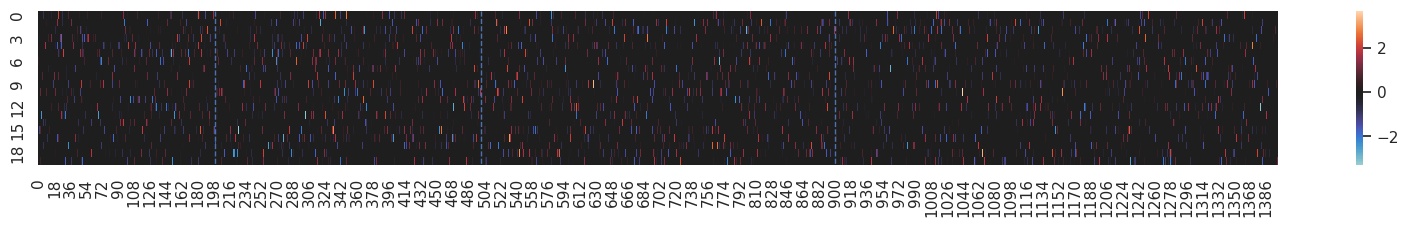

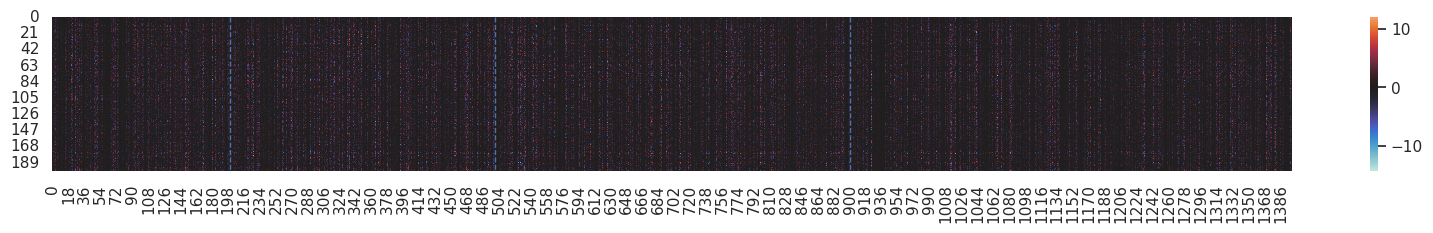

In [10]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(dg.y, vlines=vlines, center=0)

In [11]:
mdata = dg.to_mdata()
mdata

MuData object with n_obs × n_vars = 200 × 1400
  obsm:	'z'
  4 modalities
    feature_group_0:	200 x 200
      varm:	'w', 'w_mask'
    feature_group_1:	200 x 300
      varm:	'w', 'w_mask'
    feature_group_2:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_3:	200 x 500
      varm:	'w', 'w_mask'

In [12]:
model = MOFA(n_factors=dg.n_factors, sparsity_prior="Horseshoe")
model.add_data(data=mdata, na_strategy=None)


Using custom guide.


In [13]:
model.fit(likelihoods=mdata.uns['likelihoods'],  epochs=10000, num_particles=20, learning_rate=0.01, verbose_epochs=500, min_delta=0.01)

2023-05-09 17:15:45,083 - root - INFO - Guessed max_plate_nesting = 4
Epoch      0:        3449.45 	
Epoch    500:         966.94 	|  71.97%	|  23.18s
Epoch   1000:         884.59 	|   8.52%	|  23.57s
Epoch   1500:         826.64 	|   6.55%	|  23.51s
Epoch   2000:         782.78 	|   5.31%	|  27.04s
Epoch   2500:         755.78 	|   3.45%	|  34.38s
Epoch   3000:         746.87 	|   1.18%	|  34.12s
Epoch   3500:         744.55 	|   0.31%	|  34.07s
Epoch   4000:         740.59 	|   0.53%	|  34.13s
Epoch   4500:         739.08 	|   0.20%	|  34.06s
Epoch   5000:         736.27 	|   0.38%	|  34.15s
Epoch   5500:         735.83 	|   0.06%	|  34.12s
Epoch   6000:         735.86 	|  -0.00%	|  34.18s
Epoch   6500:         735.38 	|   0.07%	|  34.08s
Epoch   7000:         735.41 	|  -0.00%	|  34.12s


KeyboardInterrupt: 

In [14]:
model._guide.mode('z').shape

torch.Size([200, 20, 1])

In [15]:
# z_hat = model._guide.median()['z']
# w_hat = model._guide.median()['unscaled_w'] * model._guide.median()['w_scale']

# z_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.z')
# w_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.w')
# sigma_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.sigma')

# z_hat = model._guide.median()['z']
# w_hat = model._guide.median()['w']
# w_hat = torch.cat([model._guide.median()[f'w_view_{m}'].squeeze() for m in range(n_views)], dim=1)
z_hat = model._guide.mode('z')
w_hat = torch.cat([model._guide.mode(f'w_view_{m}').squeeze() for m in range(n_views)], dim=1)
# sigma_hat = model._guide.median()['sigma']

z_hat = z_hat.detach().cpu().numpy().squeeze()
w_hat = w_hat.detach().cpu().numpy().squeeze()

# z_hat = model.get_factor_scores()
# w_hat = np.concatenate([model.get_factor_loadings()[vn] for vn in model.view_names], axis=1)

x_hat = np.matmul(z_hat, w_hat)

# sigma_hat = sigma_hat.detach().cpu().numpy().squeeze()
print(z_hat.shape, w_hat.shape, x_hat.shape)


(200, 20) (20, 1400) (200, 1400)


<Axes: >

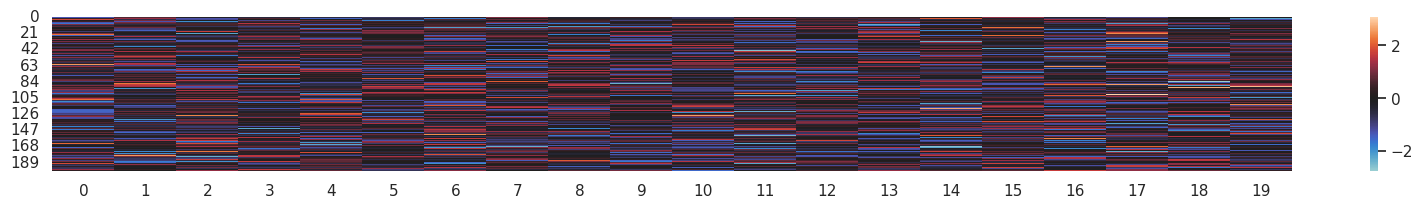

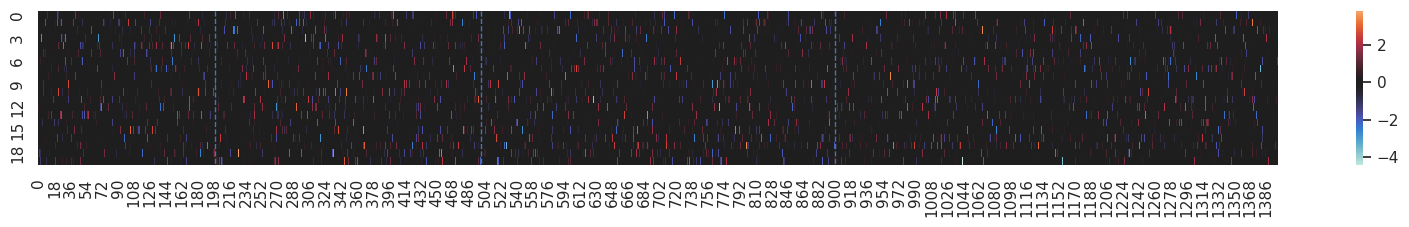

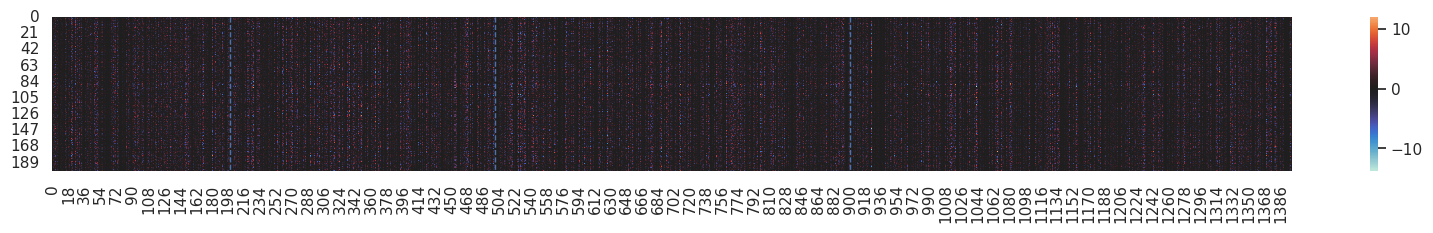

In [16]:

lined_heatmap(z_hat, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)
lined_heatmap(x_hat, vlines=vlines, center=0)
# lined_heatmap(sigma_hat[np.newaxis, :], vlines=vlines, center=0)

<Axes: >

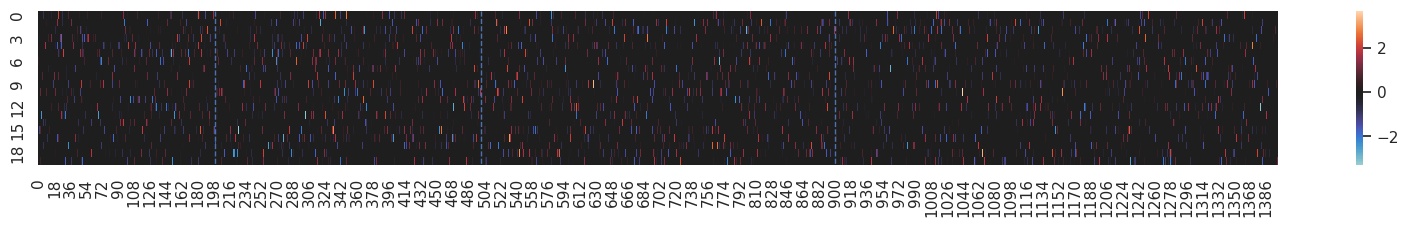

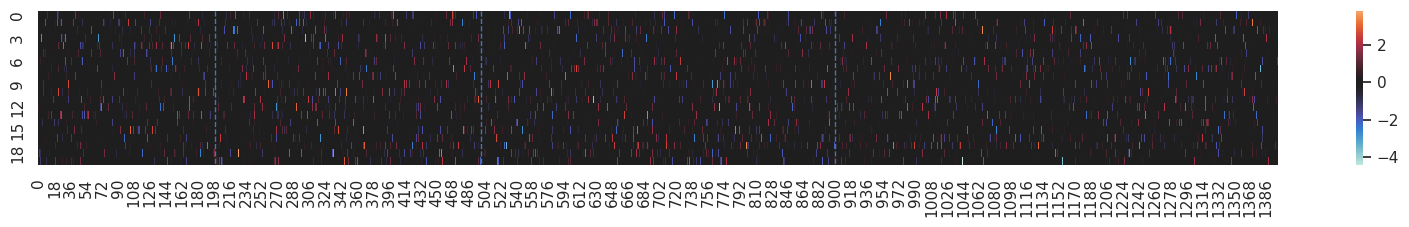

In [17]:

lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)

In [18]:
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr

from sklearn.metrics import pairwise_distances, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
r2_score(dg.y, x_hat)

-0.7163710427730688

In [20]:
def get_opt_thresh(X, Y, thresh_min=0, thresh_max=1, n_thresh=101):
    thresh_max = min(thresh_max, Y.max())
    print(thresh_max)
    thresholds = np.linspace(thresh_min, thresh_max, n_thresh)
    f1s = []
    for threshold in thresholds:
        prec, rec, f1, _ = precision_recall_fscore_support(
            X.flatten(), (Y > threshold).flatten(), average="binary"
        )
        f1s.append(f1)

    return thresholds[np.argmax(f1s)]

In [21]:
opt_order = linear_sum_assignment(-np.abs(pairwise_distances(
    dg.w,
        w_hat,
        metric=lambda a, b: pearsonr(a, b)[0],
        force_all_finite=False,
    )))[-1]
opt_order

array([10, 16, 17, 13,  1,  4, 12,  8, 14, 11, 19, 15,  7,  3,  5, 18,  0,
        9,  2,  6])

In [22]:
# threshold = 0.1
# opt_order = muvi.tl.optim_perm(cosine_similarity(dg.w_mask, np.abs(w_hat) > threshold)).argmax(axis=0)
# opt_order

In [23]:
w_hat = w_hat[opt_order, :]
z_hat = z_hat[:, opt_order]

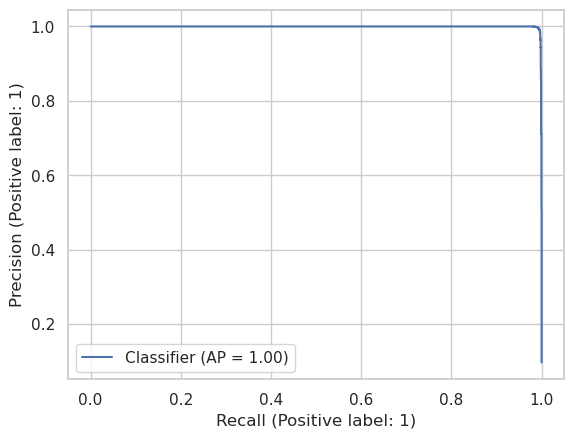

In [24]:
PrecisionRecallDisplay.from_predictions(dg.w_mask.flatten(), np.abs(w_hat).flatten())

In [25]:
threshold = get_opt_thresh(
    dg.w_mask,
    w_hat,
    0,
    5,
)
threshold

3.7982545


/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.11394763469696045

<Axes: >

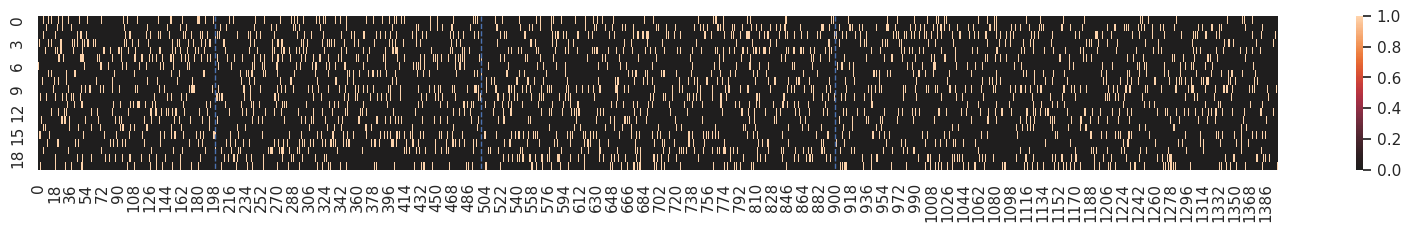

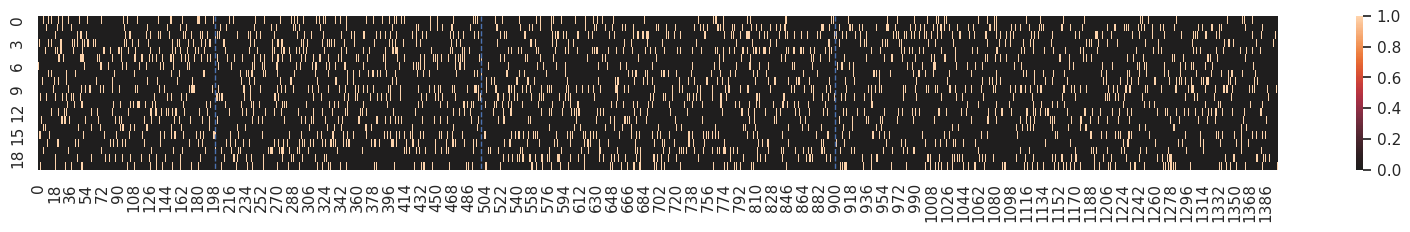

In [26]:
lined_heatmap(dg.w_mask, vlines=vlines, center=0)
lined_heatmap(np.abs(w_hat) > threshold, vlines=vlines, center=0)

In [27]:
precision_recall_fscore_support((dg.w_mask).flatten(), (np.abs(w_hat) > threshold).flatten(), average="binary")

(0.9992484028560692, 0.985910270671116, 0.9925345278088838, None)

In [28]:
pyro.get_param_store().keys()

dict_keys(['FactorModel._guide.locs.z', 'FactorModel._guide.scales.z', 'FactorModel._guide.locs.tau_view_0', 'FactorModel._guide.scales.tau_view_0', 'FactorModel._guide.locs.lambda_view_0', 'FactorModel._guide.scales.lambda_view_0', 'FactorModel._guide.locs.w_view_0', 'FactorModel._guide.scales.w_view_0', 'FactorModel._guide.locs.sigma_view_0', 'FactorModel._guide.scales.sigma_view_0', 'FactorModel._guide.locs.tau_view_1', 'FactorModel._guide.scales.tau_view_1', 'FactorModel._guide.locs.lambda_view_1', 'FactorModel._guide.scales.lambda_view_1', 'FactorModel._guide.locs.w_view_1', 'FactorModel._guide.scales.w_view_1', 'FactorModel._guide.locs.sigma_view_1', 'FactorModel._guide.scales.sigma_view_1', 'FactorModel._guide.locs.tau_view_2', 'FactorModel._guide.scales.tau_view_2', 'FactorModel._guide.locs.lambda_view_2', 'FactorModel._guide.scales.lambda_view_2', 'FactorModel._guide.locs.w_view_2', 'FactorModel._guide.scales.w_view_2', 'FactorModel._guide.locs.sigma_view_2', 'FactorModel._gui

In [29]:
# model._guide.median()['pscale_0'].shape